In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint

df = pd.read_excel("fr_countvectorizer.xlsx")
y = df["label"]

def parse_dict(x):
    d = {}
    for pair in str(x).split(","):
        if ":" in pair:
            k, v = pair.split(":")
            d[k.strip()] = float(v.strip())
    return d

count_dicts = df["countvectorizer"].apply(parse_dict)

vec = DictVectorizer(sparse=True)
X = vec.fit_transform(count_dicts)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

param_dist = {
    "n_estimators": randint(100, 400),
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": randint(2, 15),
    "min_samples_leaf": randint(1, 8),
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2", None]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== BEST PARAMETERS ===")
print(search.best_params_)

print("\n=== BEST CV SCORE (F1 weighted) ===")
print(search.best_score_)

print("\n=== EVALUATION REPORT ===")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 25 candidates, totalling 75 fits

=== BEST PARAMETERS ===
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 114}

=== BEST CV SCORE (F1 weighted) ===
0.8583431507270974

=== EVALUATION REPORT ===
              precision    recall  f1-score   support

          CG       0.85      0.88      0.87      4044
          OR       0.88      0.84      0.86      4043

    accuracy                           0.86      8087
   macro avg       0.86      0.86      0.86      8087
weighted avg       0.86      0.86      0.86      8087



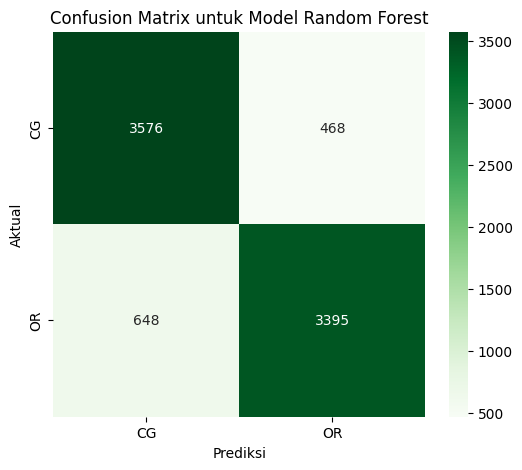

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = ["CG", "OR"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix untuk Model Random Forest")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()